In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

In [80]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("../exercises").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from part4_superposition_and_saes.utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)
import part4_superposition_and_saes.tests as tests
import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

current PyTorch install was built with MPS enabled.
MPS is available


# TMH: Superposition in a Nonprivileged Basis

# Define Model

In [84]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 6
    tree_depth: int = 2
    branching_factor: int = 2
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0

class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)

        self.device = device


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        pass # See below for solutions


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `model.importance` will always have shape (n_instances, n_features).
        '''
        pass # See below for solutions


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


tests.test_model(Model)

All tests in `test_model` passed!


In [86]:
def generate_batch(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of data. We'll return to this function later when we apply correlations.
    '''

    n_features = self.cfg.branching_factor ** (self.cfg.tree_depth + 1) - 1

    feat = t.zeros((batch_size, self.cfg.n_instances, n_features))

    rand_shape = (batch_size, self.cfg.n_instances)

    for level in range(self.cfg.tree_depth+1):
        if level == 0:
            feat[:, :, 0] = (t.ones(rand_shape))
            continue

        start_idx = 2**(level) - 1

        for i in range(2**(level-1)):
            feat[:, :, start_idx + 2*i] = (t.rand(rand_shape) > 0.5).to(t.int)
            feat[:, :, start_idx + 2*i + 1] = 1 - feat[:, :, start_idx + 2*i]

            # we need to zero out inactive features
            parent_idx = (start_idx + 2*i - 1) // 2
            feat[:, :, start_idx + 2*i] *= feat[:, :, parent_idx]
            feat[:, :, start_idx + 2*i + 1] *= feat[:, :, parent_idx]

    # shave off root
    feat = feat[:, :, 1:]

    feat = feat.to(self.device)

    return feat


def generate_batch_allow_zero_childs(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of data. We'll return to this function later when we apply correlations.
    '''

    n_features = self.cfg.branching_factor ** (self.cfg.tree_depth + 1) - 1

    feat = t.zeros((batch_size, self.cfg.n_instances, n_features))

    rand_shape = (batch_size, self.cfg.n_instances)

    for level in range(self.cfg.tree_depth+1):
        if level == 0:
            feat[:, :, 0] = (t.ones(rand_shape))
            continue

        start_idx = 2**(level) - 1

        for i in range(2**(level-1)):
            #50% chance that the child is zero
            one = (t.rand(rand_shape) > 0.5).to(t.int)
            two = (t.rand(rand_shape) > 0.5).to(t.int)
            feat[:, :, start_idx + 2*i] = ((one - two) == 1).to(t.int)
            feat[:, :, start_idx + 2*i + 1] = ((two - one) == 1).to(t.int)
            
            # we need to zero out inactive features
            parent_idx = (start_idx + 2*i - 1) // 2
            feat[:, :, start_idx + 2*i] *= feat[:, :, parent_idx]
            feat[:, :, start_idx + 2*i + 1] *= feat[:, :, parent_idx]

    # shave off root
    feat = feat[:, :, 1:]

    feat = feat.to(self.device)

    return feat

Model.generate_batch = generate_batch


In [87]:
def calculate_loss(
    self: Model,
    out: Float[Tensor, "batch instances features"],
    batch: Float[Tensor, "batch instances features"],
) -> Float[Tensor, ""]:
    '''
    Calculates the loss for a given batch, using this loss described in the Toy Models paper:

        https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

    Remember, `self.importance` will always have shape (n_instances, n_features).
    '''
    error = self.importance * ((batch - out) ** 2)
    loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
    return loss

Model.calculate_loss = calculate_loss


# Tree of (2, *2)


## same importance

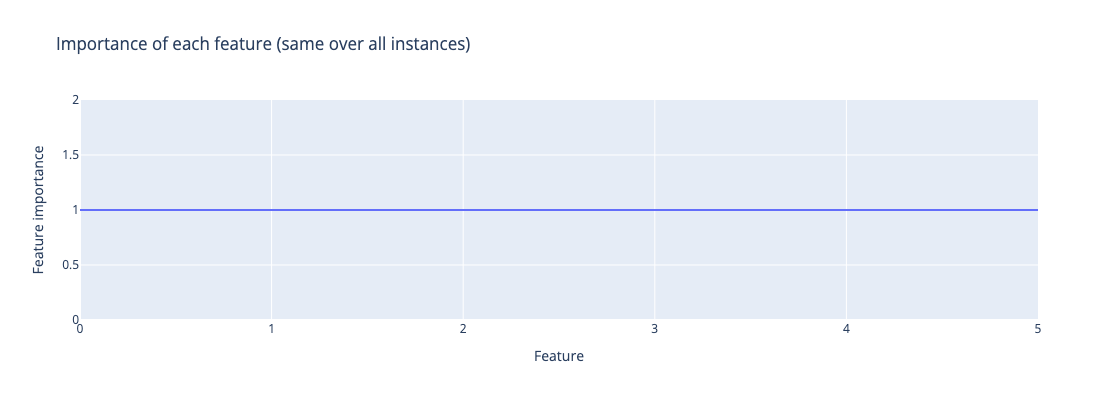

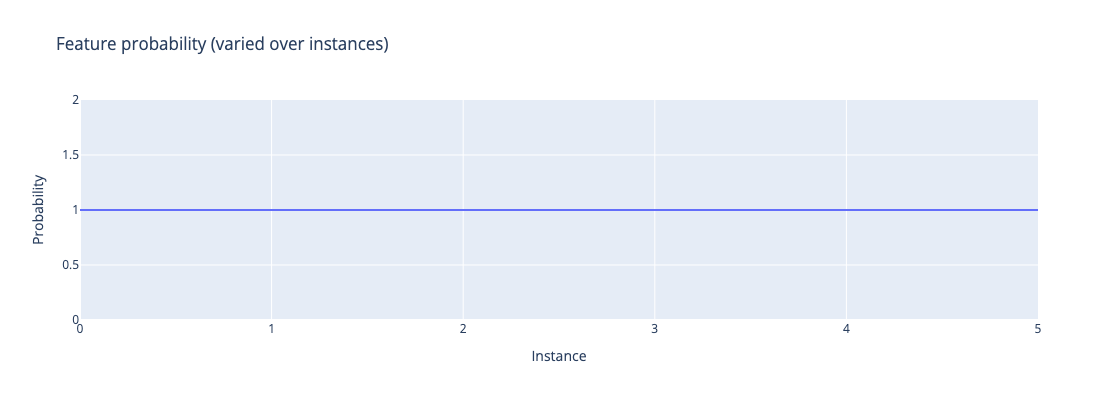

In [20]:
cfg = Config(
    n_instances = 6,
    n_features = 6,
    n_hidden = 2,
)

# importance varies within features for each instance
# importance = (0.9 ** t.arange(cfg.n_features))
importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (1 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [21]:
feature_probability.shape

torch.Size([6, 1])

In [22]:
Model.generate_batch = generate_batch

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)

model.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

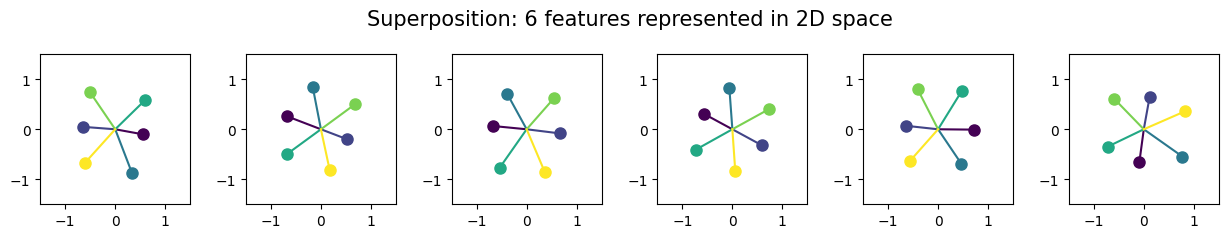

In [26]:
plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    n_rows = 1
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/3859457864.py:141: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/3859457864.py:157: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



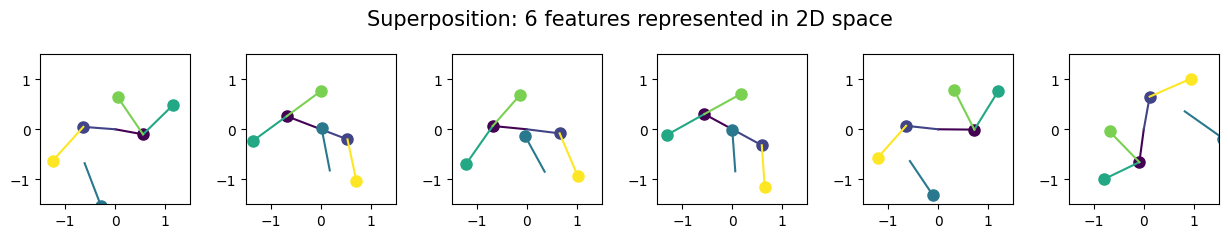

In [44]:
plot_features_in_2d_edit(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    n_rows = 1
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

In [77]:
from part4_superposition_and_saes.utils import *

def plot_features_in_2d_edit(
    W: Union[list, Float[Tensor, "timesteps instances d_hidden feats"]],
    colors = None, # shape [timesteps instances feats]
    title: Optional[str] = None,
    subplot_titles: Optional[List[str]] = None,
    save: Optional[str] = None,
    colab: bool = False,
    n_rows: bool = None,
    adjustable_limits: bool = False,
    absolute_limits: float = 1.5,
):
    '''
    Visualises superposition in 2D.

    If values is 4D, the first dimension is assumed to be timesteps, and an animation is created.
    '''

    # Convert values to 4D for consistency (note that values might also be a list)
    # Also, for consistency we have values be a list of lists of 2D tensors (cause they might not stack)
    if isinstance(W, Tensor): W = W.detach().cpu()
    n_dims = W[0][0].ndim + 2 # This works if values is wrapped with 0 / 1 / 2 lists
    for _ in range(n_dims, 4):
        W = [W]
    W: List[List[Tensor]] = [[W_instance.T for W_instance in W_timestep] for W_timestep in W]
    # So values is a list of lists of tensors, where each tensor corresponds to one instance at one timestep
    
    # Get dimensions
    n_timesteps = len(W)
    n_instances = len(W[0])

    # Get features per instance, and limits per instance
    n_features_per_instance = [W_instance.size(0) for W_instance in W[0]]
    if adjustable_limits:
        limits_per_instance = [
            1.5 * max(W_instance[instance_idx].abs().max().item() for W_instance in W)
            for instance_idx in range(n_instances)
        ]
    else:
        limits_per_instance = [absolute_limits for _ in range(n_instances)]

    # Use `n_instances` to figure out how many rows & cols we want (by default just 1 row)
    if n_rows is None:
        n_rows, n_cols = 1, n_instances
        row_col_tuples = [(0, i) for i in range(n_instances)]
    else:
        n_cols = n_instances // n_rows
        row_col_tuples = [(i // n_cols, i % n_cols) for i in range(n_instances)]

    # Set correct matplotlib backend (if it's an animation then we have to open it in a new window)
    if not(colab):
        set_matplotlib_backend("qt" if n_timesteps > 1 else "inline")

    # ! This is the section where we convert colors to 3D, with shape [timesteps, instances, features]. Several different cases to handle.
    colors = copy(colors)
    # If colors is 0D (i.e. none, or a single string color), make it 2D (i.e. same for all features & instance & timesteps)
    if isinstance(colors, str) or (colors is None):
        colors = [[colors for _ in range(n_feats)] for n_feats in n_features_per_instance]
    # If colors is 1D (i.e. it's a list of colors per timestep), make it 3D (i.e. broadcast over features & instances)
    if isinstance(colors, list) and len(colors) == n_timesteps:
        for i, colors_timestep in enumerate(colors):
            if isinstance(colors_timestep, str) or (colors_timestep is None):
                colors[i] = [[colors_timestep for _ in range(n_feats)] for n_feats in n_features_per_instance]
    # If colors is 1D (i.e. it's a list of colors per feature), broadcast this across all instances
    # (Note, if we want 1D but to broadcast across features not instances, we need to pass e.g. [["red"], ["blue"]] not ["red", "blue"])
    if isinstance(colors, list) and isinstance(colors[0], str):
        colors = [colors for _ in range(n_instances)]
    # If colors is 1D in the other way (i.e. a list of colors per instance), broadcast this across all features
    if isinstance(colors, list) and isinstance(colors[0], list) and isinstance(colors[0][0], str) and len(colors[0]) == 1:
        colors = [[c[0] for _ in range(n_feats)] for c, n_feats in zip(colors, n_features_per_instance)]
    # If colors is 2D (i.e. we have colors for each (instance, feature)) then broadcast this across all timesteps
    if any([
        colors is None,
        isinstance(colors, list) and isinstance(colors[0], list) and ((colors[0][0] is None) or isinstance(colors[0][0], str)),
        (isinstance(colors, Tensor) or isinstance(colors, Arr)) and colors.ndim == 2,
    ]):
        colors = [colors for _ in range(n_timesteps)]
    # Now that colors has 3D shape [timesteps, instances, features] we can convert it to nested lists of strings
    colors = [[[
                parse_colors_for_superposition_plot(c_feat)
                for c_feat in c_inst
            ] for c_inst in c_timestep
        ] for c_timestep in colors
    ]
    # Finally, we double the length of colors if they're a list of length n_instances//2, because this is how we plot W_enc and W_dec
    colors = [2 * x if (isinstance(x, list) and (len(x) == n_instances // 2)) else x for x in colors]

    # Same for subplot titles & titles: we want to give them a `n_timesteps` dimension
    if subplot_titles is not None:
        if isinstance(subplot_titles, list) and isinstance(subplot_titles[0], str):
            subplot_titles = [subplot_titles for _ in range(n_timesteps)]
    if title is not None:
        if isinstance(title, str):
            title = [title for _ in range(n_timesteps)]

    # Create a figure and axes, and make sure axs is a 2D array
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2.5*n_rows))
    axs = np.broadcast_to(axs, (n_rows, n_cols))
    
    # If there are titles, add more spacing for them
    fig.subplots_adjust(bottom=0.2, top=(0.8 if title else 0.9), left=0.1, right=0.9, hspace=0.5)
    
    # Initialize lines and markers
    lines = []
    markers = []
    for instance_idx, ((row, col), n_feats, limits_per_instance) in enumerate(zip(row_col_tuples, n_features_per_instance, limits_per_instance)):

        # Get the right line width for this particular instance (smaller if we're plotting a lot of data)
        linewidth, markersize = (1, 4) if (n_feats >= 25) else (1.5, 8)

        # Get the right axis, and set the limits
        ax = axs[row, col]
        ax.set_xlim(-limits_per_instance, limits_per_instance)
        ax.set_ylim(-limits_per_instance, limits_per_instance)
        ax.set_aspect('equal', adjustable='box')

        # Add all the features for this instance
        instance_lines = []
        instance_markers = []
        for feature_idx in range(n_feats):
            line, = ax.plot([], [], color=colors[0][instance_idx][feature_idx], lw=linewidth)
            marker, = ax.plot([], [], color=colors[0][instance_idx][feature_idx], marker='o', markersize=markersize)
            instance_lines.append(line)
            instance_markers.append(marker)
        lines.append(instance_lines)
        markers.append(instance_markers)

    def update(val):
        # I think this doesn't work unless I at least reference the nonlocal slider object
        # It works if I use t = int(val), so long as I put something like X = slider.val first. Idk why!
        if n_timesteps > 1:
            _ = slider.val
        t = int(val) 
        for instance_idx, ((row, col), n_feats) in enumerate(zip(row_col_tuples, n_features_per_instance)):
            for feature_idx in range(n_feats):
                x, y = W[t][instance_idx][feature_idx].tolist()
                
                if feature_idx < 2:            
                    lines[instance_idx][feature_idx].set_data([0, x], [0, y])
                    markers[instance_idx][feature_idx].set_data(x, y)

                elif feature_idx < 6:
                    # get the parent idx
                    level = 2
                    start_idx = 2**(level) - 1 - 1 # -1 because we have no root
                    i = (feature_idx - start_idx)//2                    
                    parent_idx = (start_idx + 2*i - 1) // 2 
                    
                    # print(f"feature index {feature_idx} and parent index {parent_idx}")
                    x_parent, y_parent = W[t][instance_idx][parent_idx].tolist()
                    lines[instance_idx][feature_idx].set_data([x_parent, x + x_parent], [y_parent, y + y_parent])
                    markers[instance_idx][feature_idx].set_data(x_parent + x, y_parent + y)

                else:
                    level = 3
                    
                    start_idx = 2**(level) - 1 - 1 # -1 because we have no root
                    i = (feature_idx - start_idx)//2                    
                    parent_idx = (start_idx + 2*i - 1) // 2 

                    ## get parent of parent
                    level = 2
                    start_idx = 2**(level) - 1 - 1 # -1 because we have no root
                    i = (parent_idx - start_idx)//2                    
                    parent_of_parent_idx = (start_idx + 2*i - 1) // 2

                    # print(f"feature index {feature_idx} and parent index {parent_idx} and parent of parent index {parent_of_parent_idx}")

                    x_parent, y_parent = W[t][instance_idx][parent_idx].tolist()
                    x_p_of_p, y_p_of_p = W[t][instance_idx][parent_of_parent_idx].tolist()
                    
                    lines[instance_idx][feature_idx].set_data([x_parent + x_p_of_p, x + x_parent + x_p_of_p], 
                                                              [y_p_of_p + y_parent, y + y_p_of_p + y_parent])
                    markers[instance_idx][feature_idx].set_data(x_parent + x_p_of_p + x, y_p_of_p + y_parent + y)                    

                lines[instance_idx][feature_idx].set_color(colors[t][instance_idx][feature_idx])
                markers[instance_idx][feature_idx].set_color(colors[t][instance_idx][feature_idx])
            if title:
                fig.suptitle(title[t], fontsize=15)
            if subplot_titles:
                axs[row, col].set_title(subplot_titles[t][instance_idx], fontsize=12)
        fig.canvas.draw_idle()
    
    def play(event):
        _ = slider.val
        for i in range(n_timesteps):
            update(i)
            slider.set_val(i)
            plt.pause(0.05)
        fig.canvas.draw_idle()

    if n_timesteps > 1:
        # Create the slider
        ax_slider = plt.axes([0.15, 0.05, 0.7, 0.05], facecolor='lightgray')
        slider = Slider(ax_slider, 'Time', 0, n_timesteps - 1, valinit=0, valfmt='%1.0f')

        # Call the update function when the slider value is changed / button is clicked
        slider.on_changed(update)

        # Initialize the plot
        play(0)
    else:
        update(0)

    # Save
    if isinstance(save, str):
        ani = FuncAnimation(fig, update, frames=n_timesteps, interval=50, repeat=False)
        ani.save(save, writer='pillow', fps=25)
    elif colab:
        ani = FuncAnimation(fig, update, frames=n_timesteps, interval=50, repeat=False)
        clear_output()
        display(HTML(ani.to_html5_video()))
        return

    plt.show()

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/1637707355.py:140: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/1637707355.py:157: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



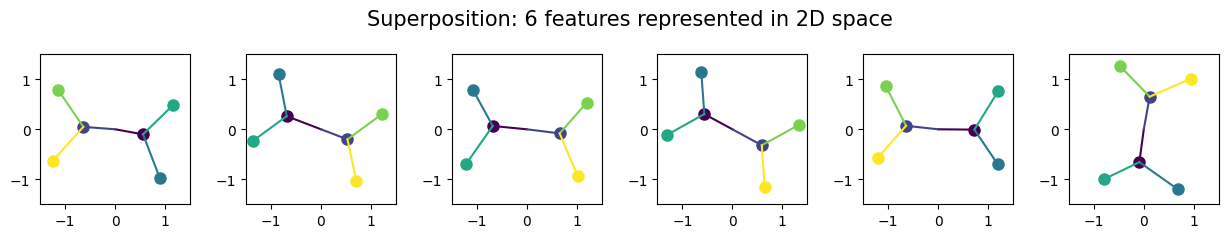

In [56]:
plot_features_in_2d_edit(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    n_rows = 1
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

Some observations:
- the parent vectors are close to 180 degrees to each other
- the projection of the child vector onto the parent vector are approximately equal to each other

In [124]:
## parent vectors are close to 180 degrees to each other

F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, 1])

tensor([-0.9941, -0.9812, -1.0000, -0.9763, -1.0000], device='mps:0')

projection of the child vectors are the same 

In [165]:
F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, 2]) * t.linalg.vector_norm(model.W.detach()[:, :, 2], dim = 1)

tensor([0.4558, 0.4950, 0.4795, 0.5249, 0.5896], device='mps:0')

In [166]:
F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, 3]) * t.linalg.vector_norm(model.W.detach()[:, :, 3], dim = 1)

tensor([0.4558, 0.4950, 0.4795, 0.5249, 0.5896], device='mps:0')

In [167]:
F.cosine_similarity(model.W.detach()[:, :, 1], model.W.detach()[:, :, 4]) * t.linalg.vector_norm(model.W.detach()[:, :, 4], dim = 1)

tensor([0.5636, 0.4999, 0.4516, 0.5720, 0.5609], device='mps:0')

In [168]:
F.cosine_similarity(model.W.detach()[:, :, 1], model.W.detach()[:, :, 5]) * t.linalg.vector_norm(model.W.detach()[:, :, 5], dim = 1)

tensor([0.5636, 0.4999, 0.4516, 0.5720, 0.5609], device='mps:0')

## Different Importance

In [57]:
cfg = Config(
    n_instances = 5,
    n_features = 6,
    n_hidden = 2,
)

importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)
importance = t.pow(2, importance - 1)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = None,
)

model.optimize(steps=10000)



  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

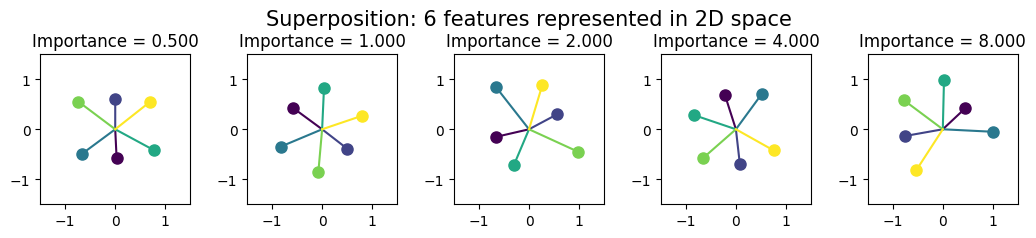

In [18]:
plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"Importance = {i:.3f}" for i in importance[:,0].squeeze()],
)

## Children can be zero, with 50% chance

In [58]:
Model.generate_batch = generate_batch_allow_zero_childs

cfg = Config(
    n_instances = 5,
    n_features = 6,
    n_hidden = 2,
)

model = Model(
    cfg = cfg,
    device = device,
    importance = None,
    feature_probability = None,
)
model.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

When parent can exist without the child, the parent vector becomes larger. The angle between the parent and the children also becomes closer to 90 degrees.

In [144]:
## parent vectors are close to 180 degrees to each other

F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, 1])

tensor([-1.0000, -1.0000, -0.9998, -1.0000, -1.0000], device='mps:0')

In [175]:
for i in range(2, 4):
    print(F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, i]) * t.linalg.vector_norm(model.W.detach()[:, :, i], dim = 1))

for i in range(4, 6):
    print(F.cosine_similarity(model.W.detach()[:, :, 1], model.W.detach()[:, :, i]) * t.linalg.vector_norm(model.W.detach()[:, :, i], dim = 1))

tensor([4.4672e-01, 1.6035e-01, 3.4178e-01, 1.3582e-07, 9.2542e-02],
       device='mps:0')
tensor([4.5286e-01, 1.6628e-01, 3.7411e-01, 1.8042e-08, 9.1916e-02],
       device='mps:0')
tensor([2.3992e-01, 4.7918e-01, 3.4146e-01, 1.0197e-07, 4.8008e-01],
       device='mps:0')
tensor([2.4523e-01, 4.7843e-01, 3.7447e-01, 1.1847e-07, 4.7555e-01],
       device='mps:0')


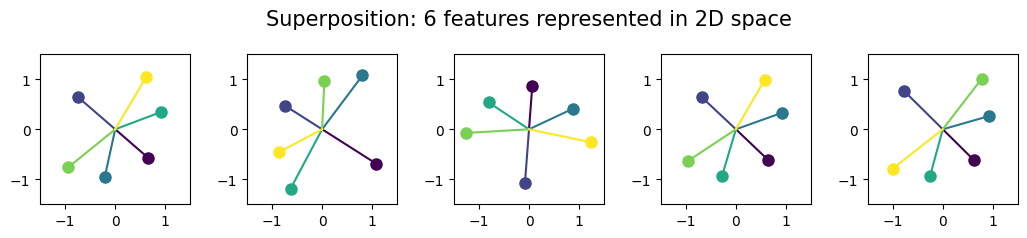

In [59]:
plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/4074330240.py:141: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/4074330240.py:158: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



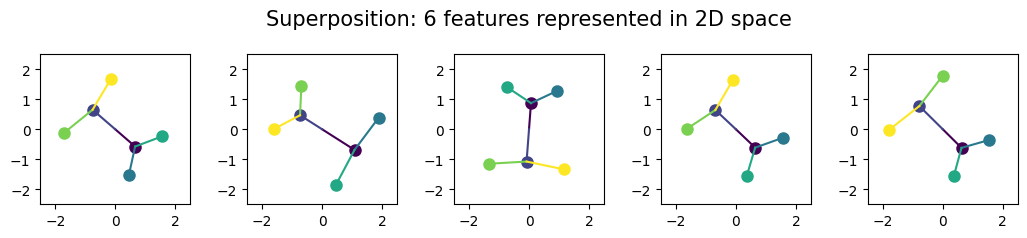

In [63]:
plot_features_in_2d_edit(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    absolute_limits = 2.5
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

### do another 10,000 steps

  0%|          | 0/10000 [00:00<?, ?it/s]

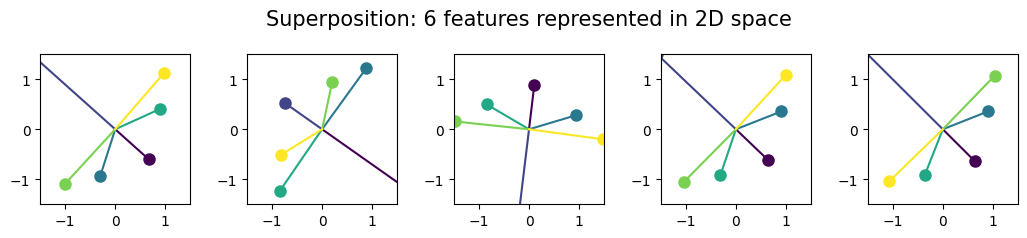

In [64]:
model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/4074330240.py:141: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/4074330240.py:158: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



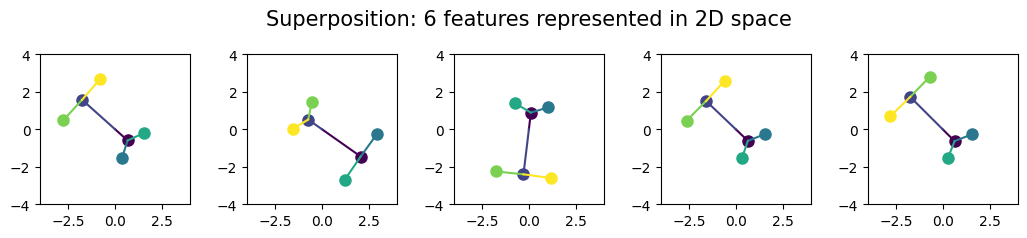

In [66]:
plot_features_in_2d_edit(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    absolute_limits = 4
    # subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

In [177]:
model.b_final[:,1]

tensor([-0.0169,  0.0082,  0.0025, -0.0269,  0.0094], device='mps:0',
       grad_fn=<SelectBackward0>)

In [154]:
## parent vectors are close to 180 degrees to each other

F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, 1])

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000], device='mps:0')

In [155]:
for i in range(2, 4):
    print(F.cosine_similarity(model.W.detach()[:, :, 0], model.W.detach()[:, :, i]) * t.linalg.vector_norm(model.W.detach()[:, :, i], dim = 1))

for i in range(4, 6):
    print(F.cosine_similarity(model.W.detach()[:, :, 1], model.W.detach()[:, :, i]) * t.linalg.vector_norm(model.W.detach()[:, :, i], dim = 1))

tensor([0.4046, 0.0272, 0.4058, 0.0264, 0.3961], device='mps:0')
tensor([0.4026, 0.0272, 0.4056, 0.0242, 0.3888], device='mps:0')
tensor([0.0252, 0.4116, 0.0258, 0.4025, 0.0242], device='mps:0')
tensor([0.0263, 0.4085, 0.0258, 0.3990, 0.0241], device='mps:0')


## More tree depth

### same importance

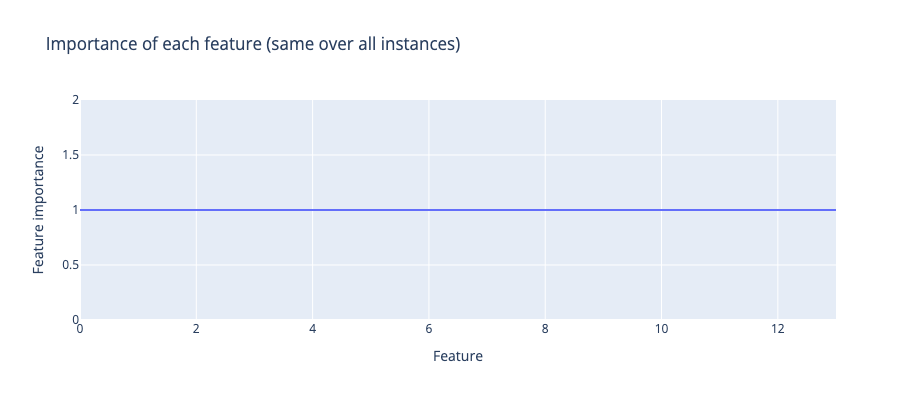

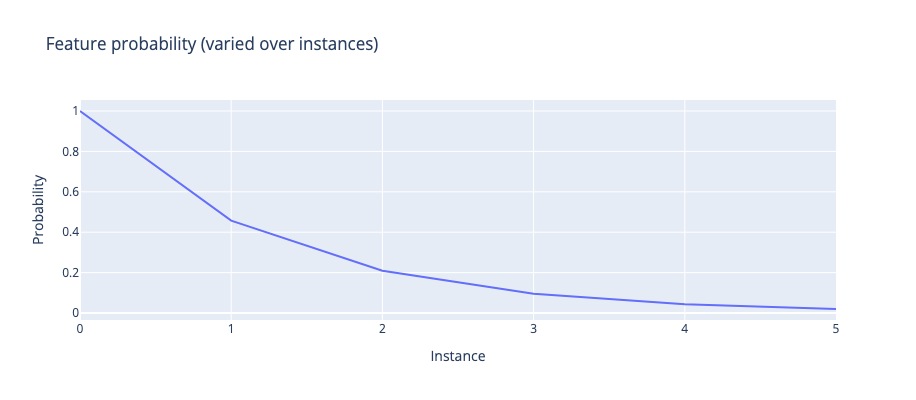

In [94]:
cfg = Config(
    n_instances = 6,
    n_features = 14,
    n_hidden = 2,
    branching_factor = 2,
    tree_depth = 3,
)


# importance varies within features for each instance
# importance = (0.9 ** t.arange(cfg.n_features))
importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [95]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

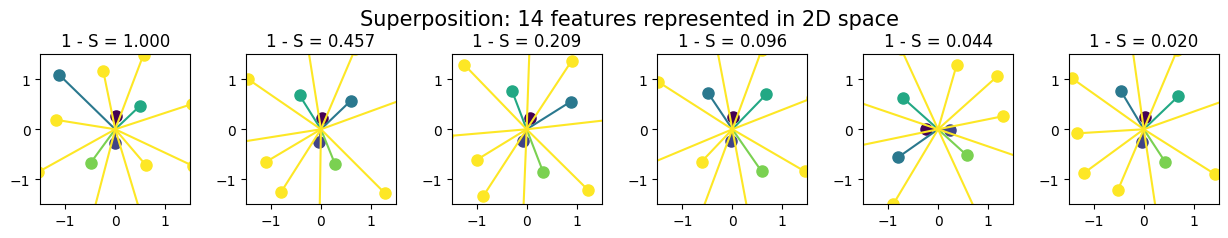

In [96]:
plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / (model.cfg.n_instances-1),
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/624141526.py:141: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/624141526.py:153: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later

/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_54289/624141526.py:175: MatplotlibDeprecationWarning:

Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later



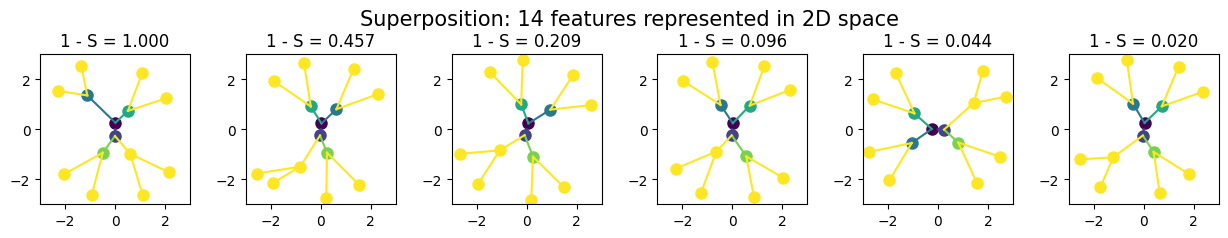

In [97]:

plot_features_in_2d_edit(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / (model.cfg.n_instances-1),
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
    absolute_limits = 3
)

### different importance

In [68]:
importance.shape

torch.Size([1, 14])

  0%|          | 0/10000 [00:00<?, ?it/s]

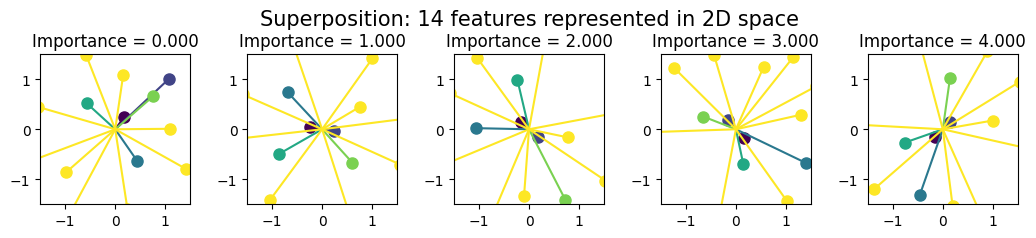

In [13]:
cfg = Config(
    n_instances = 5,
    n_features = 14,
    n_hidden = 2,
    branching_factor = 2,
    tree_depth = 3,
)

importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)
# importance = t.pow(2, importance - 1)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = None,
)



model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"Importance = {i:.3f}" for i in importance[:,0].squeeze()],
)